In [117]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
g = 9.8                  # 重力加速度 m/s^2
omega = 7.292e-5         # 地球自转角速度 rad/s
deg2rad = np.pi / 180
dy = 111.195e3 * 5           # 5° 纬度间距约 111 km/° * 5 = 555 km
dx = 111.195e3 * 5           # 近似经度间距（低纬度可略去 cosφ）
nx, ny = 16, 12
Re = 6371e3  # 地球半径

H = 8000.0             # 标高 [m]
dt = 10.0             # 时间步长 [s] (约10分钟，满足稳定性条件)
nt = int(4 * 3600 / dt)  # 24小时的步数

In [119]:
data = np.loadtxt("zuv00.dat")
flat = data.flatten()
print(flat[0:nx*ny])
print(flat[0:nx*ny].reshape(nx, ny))

[5854. 5852. 5849. 5842. 5843. 5851. 5851. 5841. 5842. 5839. 5834. 5831.
 5836. 5831. 5833. 5843. 5852. 5849. 5849. 5845. 5849. 5852. 5850. 5842.
 5850. 5859. 5848. 5846. 5853. 5850. 5845. 5854. 5851. 5852. 5858. 5853.
 5856. 5852. 5849. 5847. 5854. 5857. 5856. 5858. 5856. 5856. 5853. 5858.
 5859. 5856. 5859. 5856. 5866. 5860. 5855. 5853. 5856. 5864. 5867. 5870.
 5867. 5866. 5863. 5869. 5838. 5848. 5853. 5846. 5856. 5859. 5854. 5862.
 5869. 5869. 5877. 5879. 5877. 5878. 5879. 5877. 5788. 5796. 5803. 5799.
 5804. 5813. 5813. 5813. 5818. 5835. 5846. 5849. 5855. 5858. 5860. 5860.
 5727. 5739. 5732. 5723. 5717. 5712. 5714. 5701. 5708. 5718. 5736. 5753.
 5771. 5776. 5790. 5793. 5694. 5691. 5681. 5652. 5633. 5608. 5594. 5566.
 5559. 5560. 5569. 5587. 5615. 5638. 5648. 5656. 5635. 5618. 5604. 5568.
 5528. 5487. 5454. 5421. 5394. 5395. 5399. 5401. 5425. 5456. 5468. 5473.
 5548. 5528. 5504. 5468. 5417. 5377. 5334. 5291. 5261. 5241. 5239. 5249.
 5267. 5285. 5299. 5302. 5459. 5441. 5410. 5374. 53

In [120]:
Z0 = flat[0:nx*ny].reshape(ny, nx)
u0 = flat[nx*ny:2*nx*ny].reshape(ny, nx)
v0 = flat[2*nx*ny:3*nx*ny].reshape(ny, nx)

南端(10N) Z: [5854. 5852. 5849. 5842. 5843.]
北端(45N) Z: [5854. 5852. 5849. 5842. 5843.]


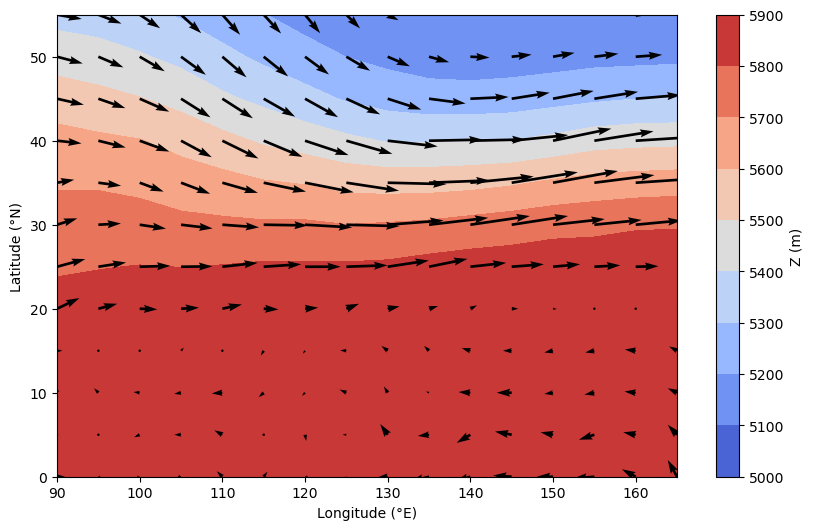

In [121]:

lat = np.linspace(0, 55, ny)   # 8格
lon = np.linspace(90, 165, nx) # 12格
Lon, Lat = np.meshgrid(lon, lat)
# print(Z)
print("南端(10N) Z:", Z[0, :5])
print("北端(45N) Z:", Z[0, :5])


plt.figure(figsize=(10, 6))
plt.contourf(Lon, Lat, Z0, cmap='coolwarm')
plt.colorbar(label='Z (m)')
plt.quiver(Lon, Lat, u0, v0, color='k')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

In [122]:
def coriolis(lat):
    """计算Coriolis参数 f = 2 * omega * sin(phi)"""
    phi = np.linspace(0, 55, ny) * deg2rad
    return 2 * omega * np.sin(phi)[:, None]  # shape (ny,1)

f = coriolis(np.linspace(0, 55, ny))


In [123]:
def ddx(F, dx):
    """中心差分求x方向导数"""
    dF = np.zeros_like(F)
    dF[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / (2 * dx)
    return dF

def ddy(F, dy):
    """中心差分求y方向导数"""
    dF = np.zeros_like(F)
    dF[1:-1, :] = (F[2:, :] - F[:-2, :]) / (2 * dy)
    return dF

def boundary(F, F0):
    """
    保持边界值不变：边界点始终取初始值
    F: 当前时间步数组
    F0: 初始时刻数组
    """
    F[0, :] = F0[0, :]         # 南边界
    F[-1, :] = F0[-1, :]       # 北边界
    F[:, 0] = F0[:, 0]         # 西边界
    F[:, -1] = F0[:, -1]       # 东边界
    return F


In [124]:
# ------------------ Step 2: 第一层（欧拉后差法） ------------------
u1 = np.zeros_like(u0)
v1 = np.zeros_like(v0)
Z1 = np.zeros_like(Z0)

for j in range(1, ny-1):
    lat_j = j * 5 * deg2rad
    dx_j = Re * np.cos(lat_j) * (5 * deg2rad)
    f_j = 2 * omega * np.sin(lat_j)
    for i in range(1, nx-1):
        du_dx = (u0[j, i+1] - u0[j, i-1]) / (2*dx_j)
        du_dy = (u0[j+1, i] - u0[j-1, i]) / (2*dy)
        dv_dx = (v0[j, i+1] - v0[j, i-1]) / (2*dx_j)
        dv_dy = (v0[j+1, i] - v0[j-1, i]) / (2*dy)
        dZ_dx = (Z0[j, i+1] - Z0[j, i-1]) / (2*dx_j)
        dZ_dy = (Z0[j+1, i] - Z0[j-1, i]) / (2*dy)

        u1[j,i] = u0[j,i] + dt * (-u0[j,i]*du_dx - v0[j,i]*du_dy - g*dZ_dx + f_j*v0[j,i])
        v1[j,i] = v0[j,i] + dt * (-u0[j,i]*dv_dx - v0[j,i]*dv_dy - g*dZ_dy - f_j*u0[j,i])
        Z1[j,i] = Z0[j,i] + dt * (-u0[j,i]*dZ_dx - v0[j,i]*dZ_dy - H*(du_dx + dv_dy))

u1 = boundary(u1, u0)
v1 = boundary(v1, v0)
Z1 = boundary(Z1, Z0)


In [125]:
# ------------------ Step 3: 第二层（再推进一层） ------------------
u2 = np.zeros_like(u0)
v2 = np.zeros_like(v0)
Z2 = np.zeros_like(Z0)

for j in range(1, ny-1):
    lat_j = j * 5 * deg2rad
    dx_j = Re * np.cos(lat_j) * (5 * deg2rad)
    f_j = 2 * omega * np.sin(lat_j)
    for i in range(1, nx-1):
        du_dx = (u1[j, i+1] - u1[j, i-1]) / (2*dx_j)
        du_dy = (u1[j+1, i] - u1[j-1, i]) / (2*dy)
        dv_dx = (v1[j, i+1] - v1[j, i-1]) / (2*dx_j)
        dv_dy = (v1[j+1, i] - v1[j-1, i]) / (2*dy)
        dZ_dx = (Z1[j, i+1] - Z1[j, i-1]) / (2*dx_j)
        dZ_dy = (Z1[j+1, i] - Z1[j-1, i]) / (2*dy)

        u2[j,i] = u0[j,i] + 2*dt * (-u1[j,i]*du_dx - v1[j,i]*du_dy - g*dZ_dx + f_j*v1[j,i])
        v2[j,i] = v0[j,i] + 2*dt * (-u1[j,i]*dv_dx - v1[j,i]*dv_dy - g*dZ_dy - f_j*u1[j,i])
        Z2[j,i] = Z0[j,i] + 2*dt * (-u1[j,i]*dZ_dx - v1[j,i]*dZ_dy - H*(du_dx + dv_dy))

u2 = boundary(u2, u0)
v2 = boundary(v2, v0)
Z2 = boundary(Z2, Z0)


In [178]:
# ---------- Step 4: 蛙跃主循环 ----------
u_old, v_old, Z_old = u1, v1, Z1
u, v, Z = u2, v2, Z2

In [179]:
nt = int(24 * 3600 / dt)  # 24小时的步数
# eps = 0.1  # 滤波系数，通常 0.05~0.1 之间


for n in range(1, nt):
    u_next = np.zeros_like(u)
    v_next = np.zeros_like(v)
    Z_next = np.zeros_like(Z)

    for j in range(1, ny-1):
        lat_j = j * 5 * deg2rad
        dx_j = Re * np.cos(lat_j) * (5 * deg2rad)
        f_j = 2 * omega * np.sin(lat_j)
        for i in range(1, nx-1):
            du_dx = (u[j, i+1] - u[j, i-1]) / (2*dx_j)
            du_dy = (u[j+1, i] - u[j-1, i]) / (2*dy)
            dv_dx = (v[j, i+1] - v[j, i-1]) / (2*dx_j)
            dv_dy = (v[j+1, i] - v[j-1, i]) / (2*dy)
            dZ_dx = (Z[j, i+1] - Z[j, i-1]) / (2*dx_j)
            dZ_dy = (Z[j+1, i] - Z[j-1, i]) / (2*dy)

            u_next[j,i] = u_old[j,i] + 2*dt * (-u[j,i]*du_dx - v[j,i]*du_dy - g*dZ_dx + f_j*v[j,i])
            v_next[j,i] = v_old[j,i] + 2*dt * (-u[j,i]*dv_dx - v[j,i]*dv_dy - g*dZ_dy - f_j*u[j,i])
            Z_next[j,i] = Z_old[j,i] + 2*dt * (-u[j,i]*dZ_dx - v[j,i]*dZ_dy - H*(du_dx + dv_dy))

    u_next = boundary(u_next, u0)
    v_next = boundary(v_next, v0)
    Z_next = boundary(Z_next, Z0)

    # # ---------- 五点平滑（x方向） ----------
    # for F in [u_next, v_next, Z_next]:
    #     F[:, 2:-2] = (F[:, :-4] + 4*F[:, 1:-3] + 6*F[:, 2:-2] + 4*F[:, 3:-1] + F[:, 4:]) / 16.0
    # # ---------- 五点平滑（y方向） ----------
    # for F in [u_next, v_next, Z_next]:
    #     F[2:-2, :] = (F[:-4, :] + 4*F[1:-3, :] + 6*F[2:-2, :] + 4*F[3:-1, :] + F[4:, :]) / 16.0

    u_next = boundary(u_next, u0)
    v_next = boundary(v_next, v0)
    Z_next = boundary(Z_next, Z0)

    # --- Robert-Asselin 滤波 ---
    # u = u + eps * (u_old - 2*u + u_next)
    # v = v + eps * (v_old - 2*v + v_next)
    # Z = Z + eps * (Z_old - 2*Z + Z_next)


    u_old, v_old, Z_old = u.copy(), v.copy(), Z.copy()
    u, v, Z = u_next.copy(), v_next.copy(), Z_next.copy()

    if n % 100 == 0:
        print(f"Step {n}/{nt} complete")


Step 100/8640 complete
Step 200/8640 complete
Step 300/8640 complete
Step 400/8640 complete
Step 500/8640 complete
Step 600/8640 complete
Step 700/8640 complete
Step 800/8640 complete
Step 900/8640 complete
Step 1000/8640 complete
Step 1100/8640 complete
Step 1200/8640 complete
Step 1300/8640 complete
Step 1400/8640 complete
Step 1500/8640 complete
Step 1600/8640 complete
Step 1700/8640 complete
Step 1800/8640 complete
Step 1900/8640 complete
Step 2000/8640 complete
Step 2100/8640 complete
Step 2200/8640 complete
Step 2300/8640 complete
Step 2400/8640 complete
Step 2500/8640 complete
Step 2600/8640 complete
Step 2700/8640 complete
Step 2800/8640 complete
Step 2900/8640 complete
Step 3000/8640 complete
Step 3100/8640 complete
Step 3200/8640 complete
Step 3300/8640 complete
Step 3400/8640 complete
Step 3500/8640 complete
Step 3600/8640 complete
Step 3700/8640 complete
Step 3800/8640 complete
Step 3900/8640 complete
Step 4000/8640 complete
Step 4100/8640 complete
Step 4200/8640 complete
S

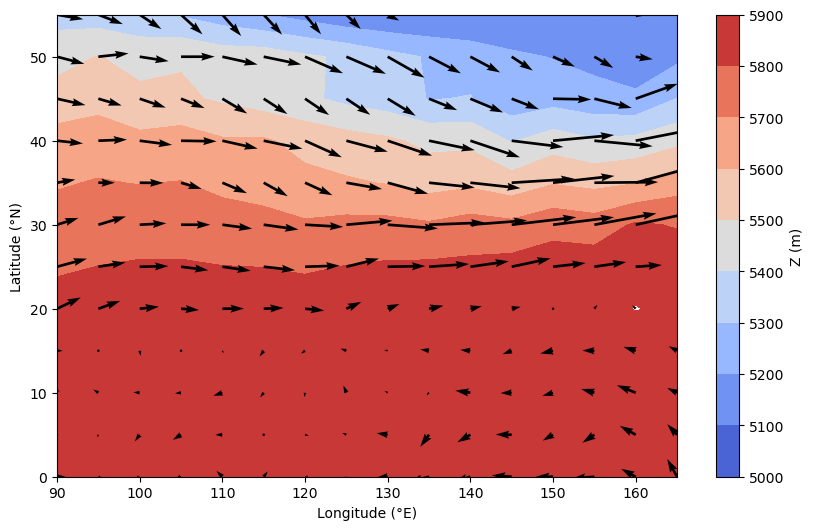

In [180]:

lat = np.linspace(0, 55, ny)   # 8格
lon = np.linspace(90, 165, nx) # 12格
Lon, Lat = np.meshgrid(lon, lat)


plt.figure(figsize=(10, 6))
plt.contourf(Lon, Lat, Z, cmap='coolwarm', levels=np.linspace(5000, 5900, 10), vmin=5000, vmax=5900)
plt.colorbar(label='Z (m)')
plt.quiver(Lon, Lat, u, v, color='k')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

In [181]:
max_diff = np.max(Z - Z0)
print(max_diff)


185.22746754443415


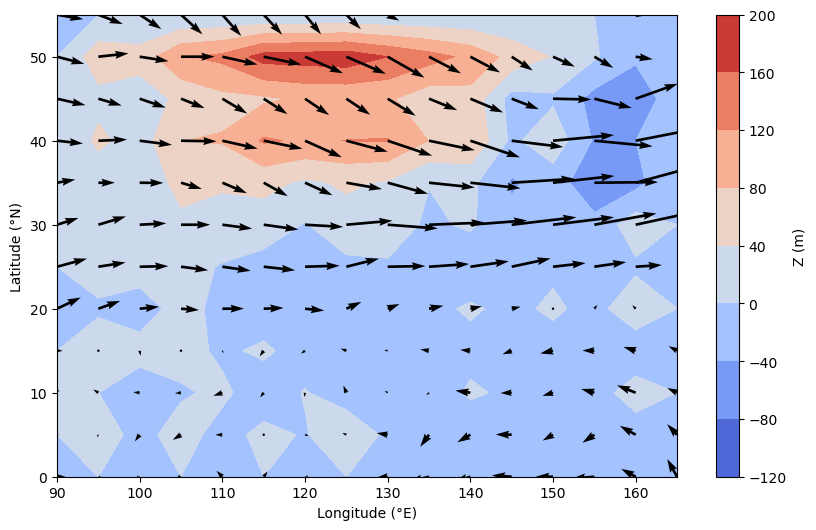

In [182]:

lat = np.linspace(0, 55, ny)   # 8格
lon = np.linspace(90, 165, nx) # 12格
Lon, Lat = np.meshgrid(lon, lat)


plt.figure(figsize=(10, 6))
plt.contourf(Lon, Lat, Z-Z0, cmap='coolwarm')
plt.colorbar(label='Z (m)')
plt.quiver(Lon, Lat, u, v, color='k')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()